# Preprocessing pipeline


This pipeline aims to serve as a semiautomatic and reproducible framework for preprocessing EEG signals prior to time-frequency-based analyses. It minimizes the manual steps required to clean the data based on visual inspection. It is advised to revisit the cleaned epochs before writing the final preprocessed file. 


## Outline

1. __Temporal filtering__

High-frequency artefacts and slow drifts are removed with a zero-phase bandpass filter using mne-Python [1]. The cutoff frequencies (0.5 - 45 Hz) can be modified in the utils folder in the configuration file (config.py). 


2. __Create epochs__ 

Epochs are nonoverlapping data segments created from the continuous data with a duration of 1 seconds. The length of epochs can be changed in the configuration file.
Epochs can be created from (1) events; there is a custom method that created epochs based on annotations in the raw data, (2) without events, data segments are created from the beginning of the raw data. 


3. __Outlier data rejection__  

    3.1. _Preliminar rejection_  
Epochs are rejected based on a global threshold on the z-score (> 3) of the epoch variance and amplitude range.

    3.2. _ICA decomposition_  
The default method is the infomax algorithm, however it can be changed in the configuration file along with the number of components and the decimation parameter. Components containing blink artefacts are automatically marked with mne-Python.
The ICA sourced can be visualized and interactively selected and rejected based on their topographies, time-courses or frequency spectra. The number of components that were removed from the data are documented in the “description” field of the epochs instance “info” structure.

    3.3. _Autoreject_  
Autoreject [2, 3] uses unsupervised learning to estimate the rejection threshold for the epochs. In order to reduce computation time that increases with the number of segments and channels, autoreject can be fitted on a representative subset of epochs (25% of total epochs). Once the parameters are learned, the solution can be applied to any data that contains channels that were used during fit.


4. __Outlier channel interpolation__

The Random Sample Consensus (RANSAC) algorithm [4] selects a random subsample of good channels to make predictions of each channel in small non-overlapping 4 seconds long time windows. It uses a method of spherical splines (Perrin et al., 1989) to interpolate the bad sensors. The sensors that were interpolated are added to the "description" field of the epochs "info" structure. 


<img src="static/preprocessing_pipeline_diagram.svg">


## References

[1] A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013, ISSN 1662-453X

[2] Mainak Jas, Denis Engemann, Federico Raimondo, Yousra Bekhti, and Alexandre Gramfort, “Automated rejection and repair of bad trials in MEG/EEG.” In 6th International Workshop on Pattern Recognition in Neuroimaging (PRNI), 2016.

[3] Mainak Jas, Denis Engemann, Yousra Bekhti, Federico Raimondo, and Alexandre Gramfort. 2017. “Autoreject: Automated artifact rejection for MEG and EEG data”. NeuroImage, 159, 417-429.

[4] Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K. M., & Robbins, K. A. (2015). The PREP pipeline: standardized preprocessing for large-scale EEG analysis. Frontiers in neuroinformatics, 9, 16.


## Import packages


```%matplotlib qt``` is the recommended backend for interactive visualization (can be slower);    

switch to ```%matplotlib inline``` for (faster) static plots

In [1]:
import os
from ipyfilechooser import FileChooser

import pandas as pd
from meeg_tools.preprocessing import *
from meeg_tools.utils.epochs import create_epochs
from meeg_tools.utils.raw import read_raw_measurement, filter_raw

%matplotlib qt

## Load raw data


See [this](https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html) documentation for help with supported file formats.  

In [2]:
# Use the widget to navigate to the experiment folder path and select an EEG file 
base_path = '/Volumes/crnl-memo-hd/raw_data_EEG/'
fc = FileChooser(base_path)
fc.filter_pattern = ['*.vhdr', '*.edf']

display(fc)

FileChooser(path='/Volumes/crnl-memo-hd/raw_data_EEG', filename='', title='HTML(value='', layout=Layout(displa…

In [3]:
locs_file_path = '/Users/weian/crnl/neuroelectrics_eeg_pilot/Starstim32.locs'
raw = read_raw_measurement(raw_file_path=fc.selected,
                           locs_file_path=locs_file_path)
print(raw.info)

Extracting EDF parameters from /Volumes/crnl-memo-hd/raw_data_EEG/20210422171216_3_EEG PALT alatt.easy_converted_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Channel locations are missing from the file
There are 3 channel positions not present in the Starstim32 file.
Assuming these (['X', 'Y', 'Z']) are not EEG channels, dropping them from Raw.
Applying channel locations to Raw instance.
<Info | 9 non-empty values
 bads: []
 ch_names: P8, T8, F8, F4, C4, P4, Fp2, Fp1, Fz, Cz, O1, Oz, O2, Pz, P3, ...
 chs: 20 EEG
 custom_ref_applied: False
 dig: 20 items (20 EEG)
 fid: 20210422171216_3_EEG PALT alatt.easy_converted_
 highpass: 0.1 Hz
 lowpass: 250.0 Hz
 meas_date: 2021-04-22 17:12:25 UTC
 nchan: 20
 projs: []
 sfreq: 500.0 Hz
>


## Temporal filtering

- bandpass filter (1 - 30 Hz)

In [4]:
settings['bandpass_filter']['low_freq'] = 1
settings['bandpass_filter']['high_freq'] = 30

In [5]:
raw_bandpass = filter_raw(raw)

Reading 0 ... 50999  =      0.000 ...   101.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done  18 out of  20 | elapsed:   10.0s remaining:    1.1s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:   10.0s finished


##  Create epochs

We will create epochs with 1 second duration from the beginning of the recording to the end.

In [6]:
settings['epochs']

{'start_time': 0.0, 'end_time': 1.0, 'duration': 1}

In [7]:
epochs = create_epochs(raw=raw_bandpass)

Creating epochs from continuous data ...
Not setting metadata
Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated


In [36]:
# Change the order of channels (optional)

ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz',
            'F4', 'F8', 'T7', 'C3', 'Cz',
            'C4', 'T8', 'P7', 'P3', 'Pz',
            'P4', 'P8', 'O1', 'Oz', 'O2']

epochs = epochs.copy().load_data().pick_channels(ch_names, ordered=True)


Loading data for 101 events and 501 original time points ...


## Run preprocessing


### 1.1. Preliminary epoch rejection

In [8]:
epochs_faster = prepare_epochs_for_ica(epochs=epochs)

Preliminary epoch rejection: 
Loading data for 102 events and 501 original time points ...
1 bad epochs dropped
Bad epochs by amplitude
	[77 78 79 80 94 95 96 97]
Bad epochs by deviation
	[80 95]
Bad epochs by variance
	[77 79 80 94 95 96 97]
Dropped 8 epochs: 77, 78, 79, 80, 94, 95, 96, 97


### 1.2. Run ICA

Since this dataset only have 20 channels, the default number of components have to be adjusted. Similalry as before, we can change it here.

In [9]:
settings['ica']['n_components'] = 18

In [10]:
ica = run_ica(epochs=epochs_faster)

Fitting ICA to data using 20 channels (please be patient, this may take a while)
Loading data for 93 events and 501 original time points ...
Selecting by number: 18 components
 
Loading data for 93 events and 501 original time points ...
Fitting ICA took 9.4s.
EOG channels are not found. Attempting to use Fp1,Fp2 channels as EOG channels.
Loading data for 93 events and 501 original time points ...
Loading data for 93 events and 501 original time points ...
Loading data for 93 events and 501 original time points ...
Loading data for 93 events and 501 original time points ...


In [21]:
# Plot component topographies
ica.plot_components()

[<Figure size 1950x1884 with 18 Axes>]

Loading data for 93 events and 501 original time points ...
Not setting metadata
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


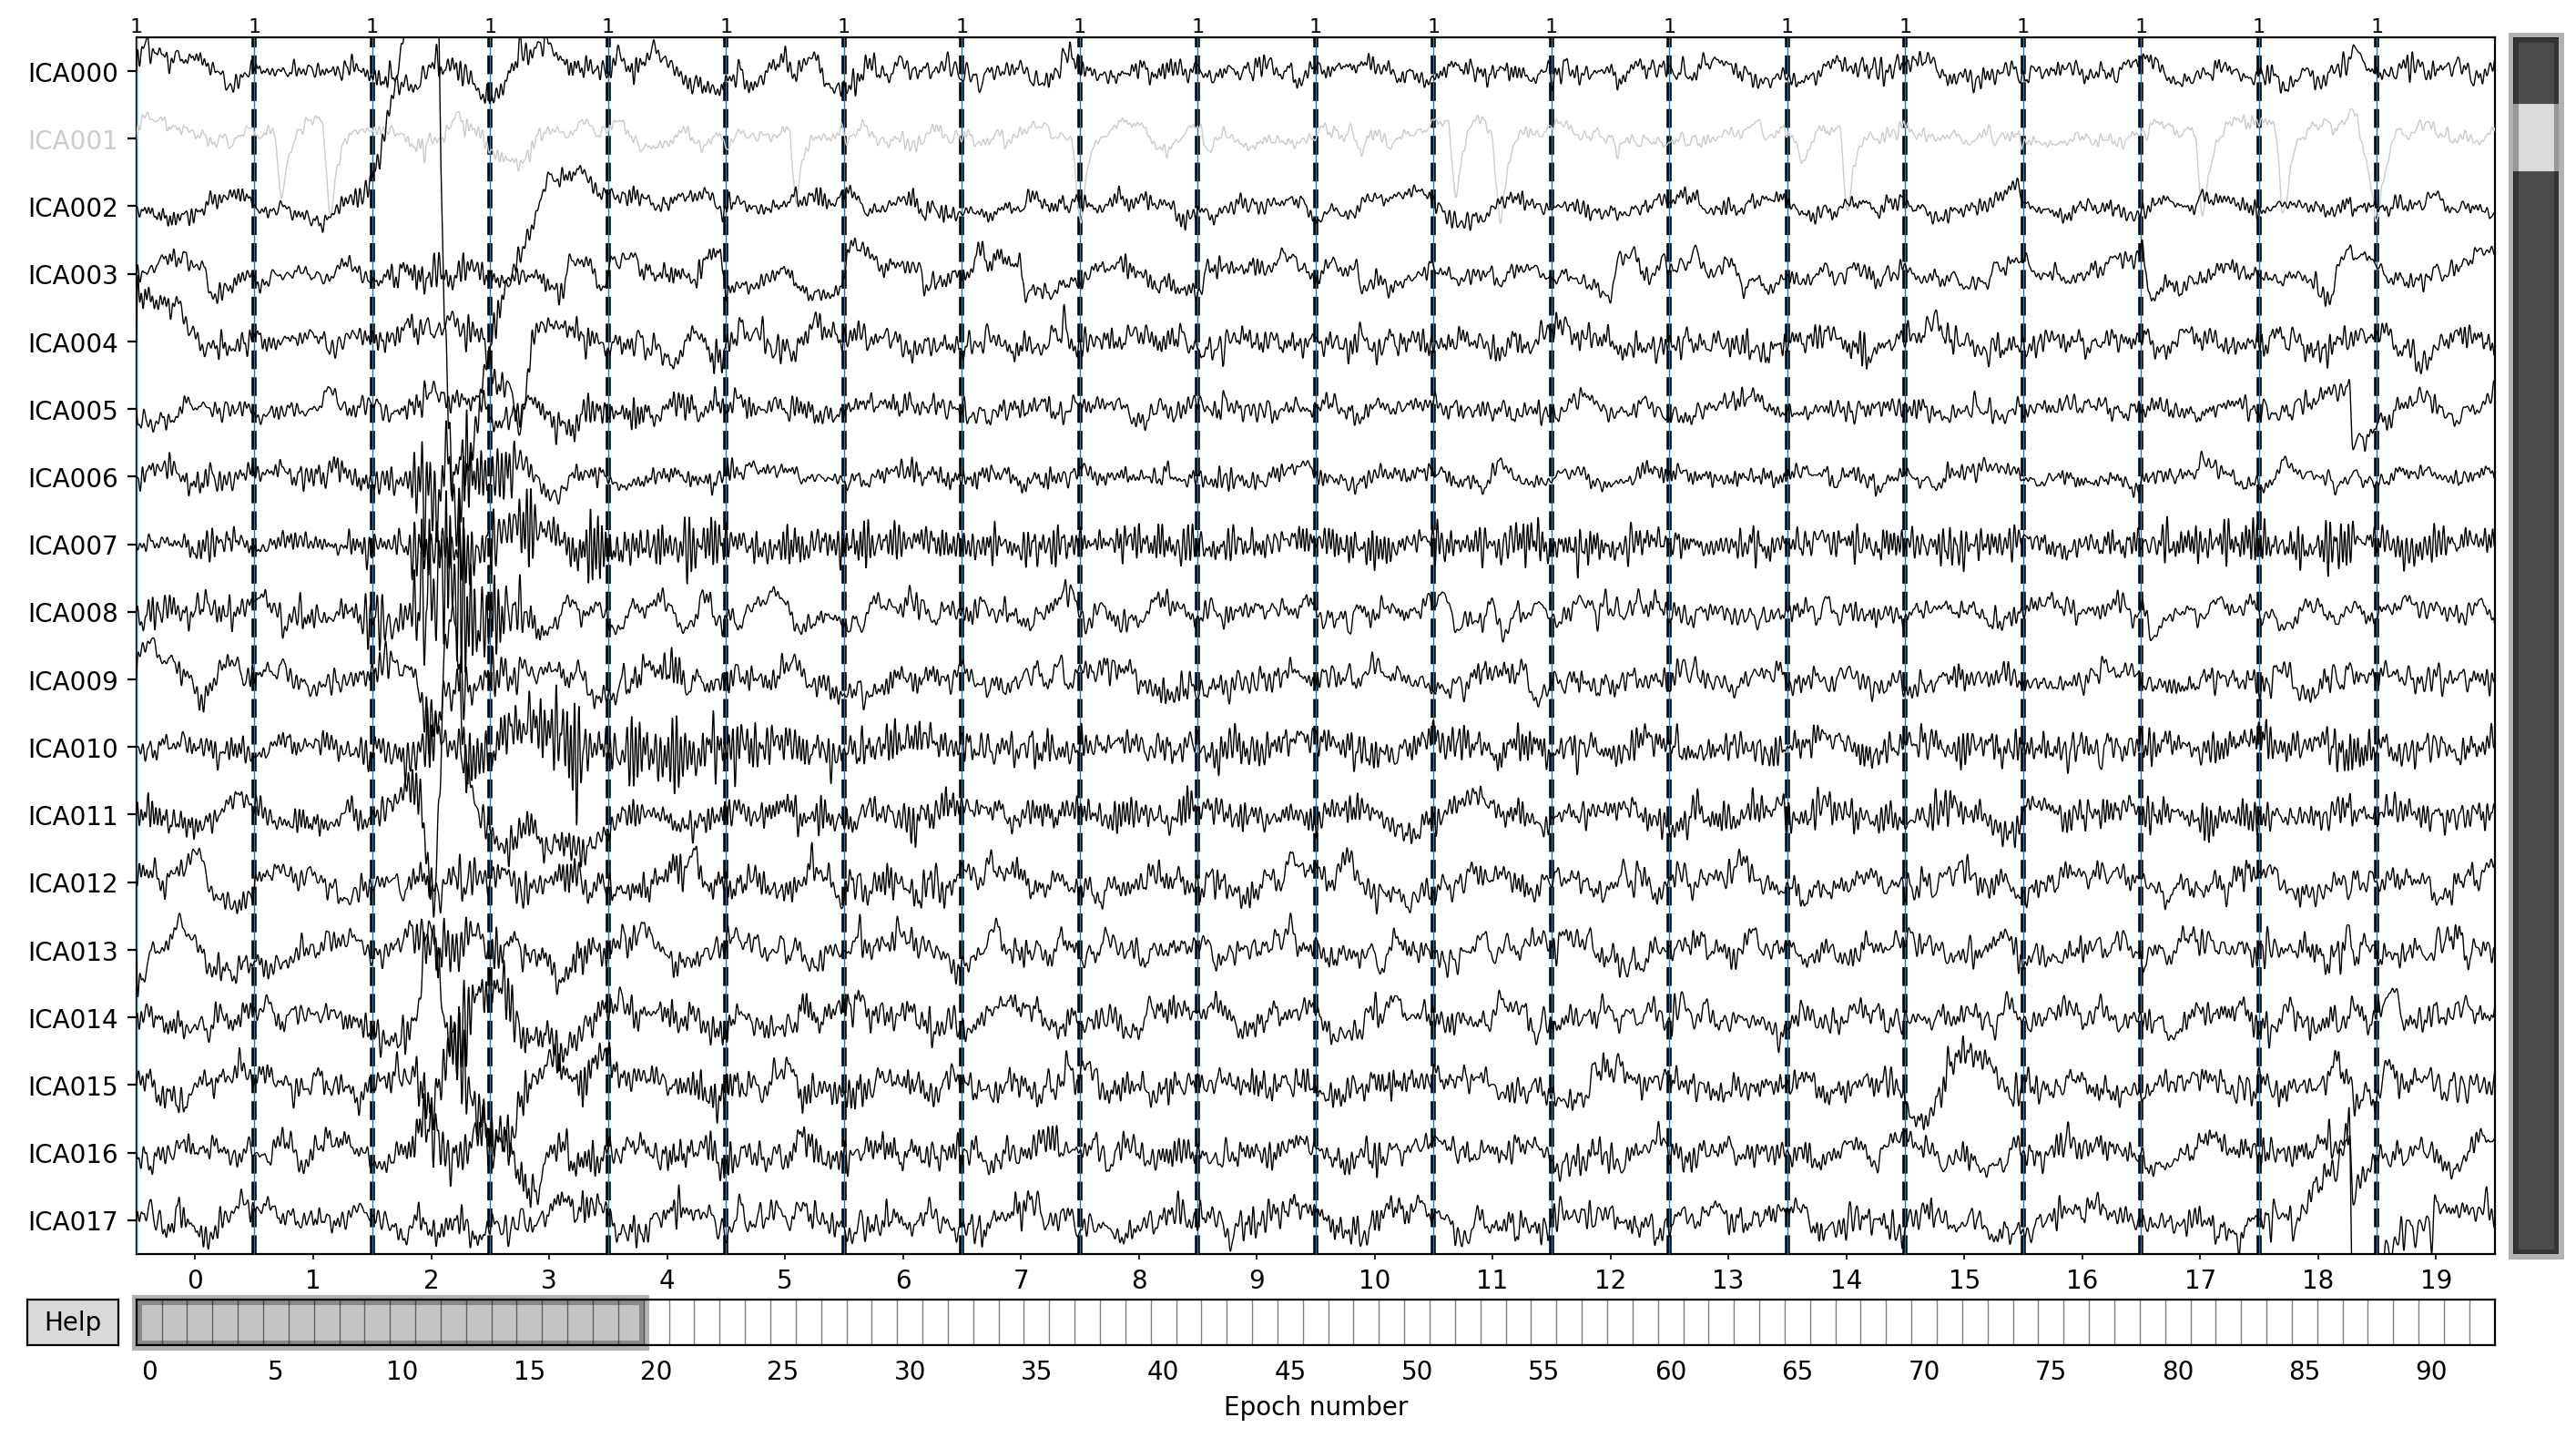

Loading data for 93 events and 501 original time points ...
Loading data for 93 events and 501 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Loading data for 93 events and 501 original time points ...
Loading data for 93 events and 501 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Loading data for 93 events and 501 original time points ...
Loading data for 93 events and 501 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Loading data 

In [11]:
# Exclude components by selecting them, right click on component name to visulize source:
ica.plot_sources(epochs_faster)

In [13]:
# After selecting the components to exclude, apply ICA to epochs
# Document the number of excluded components
ica.apply(epochs_faster.load_data())
epochs_faster.info['description'] = f'n_components: {len(ica.exclude)}'

Loading data for 93 events and 501 original time points ...
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 20 PCA components


### 1.3. Visualize ICA cleaned epochs (optional)

This step can be repeated after each preprocessing step, or you can also do a final inspection at the end. 

In [ ]:
epochs_faster.plot(n_epochs=10, scalings={'eeg': 20e-6}, title=raw.info['fid'])

### 1.4. Save cleaned epochs (recommended)

In [25]:
# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
epochs_path = os.path.join(base_path, folder_name, 'epochs')


# Create path to epoch files
if not os.path.exists(epochs_path):
    os.makedirs(epochs_path)

# Save ICA cleaned epochs 
fid = epochs_faster.info['fid']
epochs_clean_fname = f'{fid}_ICA'
postfix = '-epo.fif.gz'
epochs_faster.save(os.path.join(epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

### 1.5. Create a log file 

We can create a log file for the preprocessed data and store metadata
that could be useful to remember. You can add more columns to this, or 
remove the ones that are not needed. For documentation purporses, it is 
recommended to store the number of rejected and total epochs, the number of
ICA components that were rejected, the number of interpolated electrodes etc.
You can also add a column with "notes" to add custom descriptions about the data.

In [30]:
# Create a preprocessing log file
log_file_path = os.path.join(epochs_path, 'log.csv')

n_bad_epochs = len([drop for drop in epochs_faster.drop_log if 'FASTER' in drop or 'USER' in drop])

log = pd.DataFrame({'fid': [epochs_clean_fname],
                    'highpass': [epochs_faster.info['highpass']],
                    'lowpass': [epochs_faster.info['lowpass']],
                    'n_components': [len(ica.exclude)],
                    'n_bad_epochs': [n_bad_epochs],
                    'n_total_epochs': [len(epochs)],
                    'drop_percentage': [round(epochs_faster.drop_log_stats(), 2)],
                    't_min': [epochs_faster.tmin],
                    't_max': [epochs_faster.tmax],
                    'n_interpolated': [np.NaN],
                    'baseline': [np.NaN],
                    'notes': ['']})


if os.path.isfile(log_file_path):
    log.to_csv(log_file_path, mode='a', index=False, header=False)
else:
    log.to_csv(log_file_path, index=False)

In [31]:
log

fid  highpass  lowpass  \
0  20210422171216_3_EEG PALT alatt.easy_converted...       1.0     30.0   

   n_components  n_bad_epochs  n_total_epochs  drop_percentage  t_min  t_max  \
0             1             8             101             8.82    0.0    1.0   

   n_interpolated  baseline notes  
0             NaN       NaN

### 2.1. Run autoreject

In [14]:
reject_log = run_autoreject(epochs_faster, n_jobs=11, subset=False)

Fitting autoreject on (n=93) epochs: 


Creating augmented epochs:  35%|███▌      | 7/20 [00:00<00:00, 67.48it/s]

Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 20/20 [00:00<00:00, 22.71it/s]


Repairing epochs:   0%|          | 0/93 [00:00<?, ?it/s]

Repairing epochs:  46%|████▌     | 43/93 [00:00<00:00, 426.29it/s]

Repairing epochs: 100%|██████████| 93/93 [00:00<00:00, 411.87it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/93 [00:00<?, ?it/s]

Repairing epochs:   9%|▊         | 8/93 [00:00<00:01, 79.39it/s]

Repairing epochs:  20%|██        | 19/93 [00:00<00:00, 93.21it/s]

Repairing epochs:  31%|███       | 29/93 [00:00<00:00, 94.41it/s]

Repairing epochs:  42%|████▏     | 39/93 [00:00<00:00, 92.61it/s]

Repairing epochs:  53%|█████▎    | 49/93 [00:00<00:00, 86.92it/s]

Repairing epochs:  62%|██████▏   | 58/93 [00:00<00:00, 84.28it/s]

Repairing epochs:  72%|███████▏  | 67/93 [00:00<00:00, 64.49it/s]

Repairing epochs:  81%|████████  | 75/93 [00:01<00:00, 61.68it/s]

Repairing epochs:  88%|████████▊ | 82/93 [00:01<00:00, 59.33it/s]

Repairing epochs: 100





Estimated consensus=0.90 and n_interpolate=4

AUTOREJECT report
There are 4 bad epochs found with Autoreject. You can assess these epochs with reject_log.bad_epochs

There are 39 bad epochs where more than 15% of the channels were noisy. You can assess these epochs with reject_log.report


In [15]:
# Here you can decide how strict should be the epoch rejection.
# You can drop only those that were marked as bad epochs, or a more 
# strict rejection threshold can be if you drop epochs where more than
# 15% of the channels were marked as noisy.

# You can plot the epochs with Autoreject, where bad epochs are marked with
# red colors. 

# reject_log.plot_epochs(epochs_faster)


# rejecting only bad epochs
# epochs_autoreject = epochs_faster.copy().drop(reject_log.bad_epochs, reason='AUTOREJECT')

# rejecting those epochs too where more than 15% of the channels are marked as noisy
epochs_autoreject = epochs_faster.copy().drop(reject_log.report, reason='AUTOREJECT')

# you can plot just the bad epochs to double check how strict this rejection is
# if reject_log.report: 
#     epochs_faster[reject_log.report].plot(n_epochs=10,
#                                 scalings={'eeg': 20e-6},
#                                 n_channels=32)




Dropped 39 epochs: 0, 2, 3, 4, 5, 19, 27, 28, 34, 35, 43, 44, 50, 51, 52, 54, 61, 62, 65, 66, 67, 68, 69, 70, 71, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 92


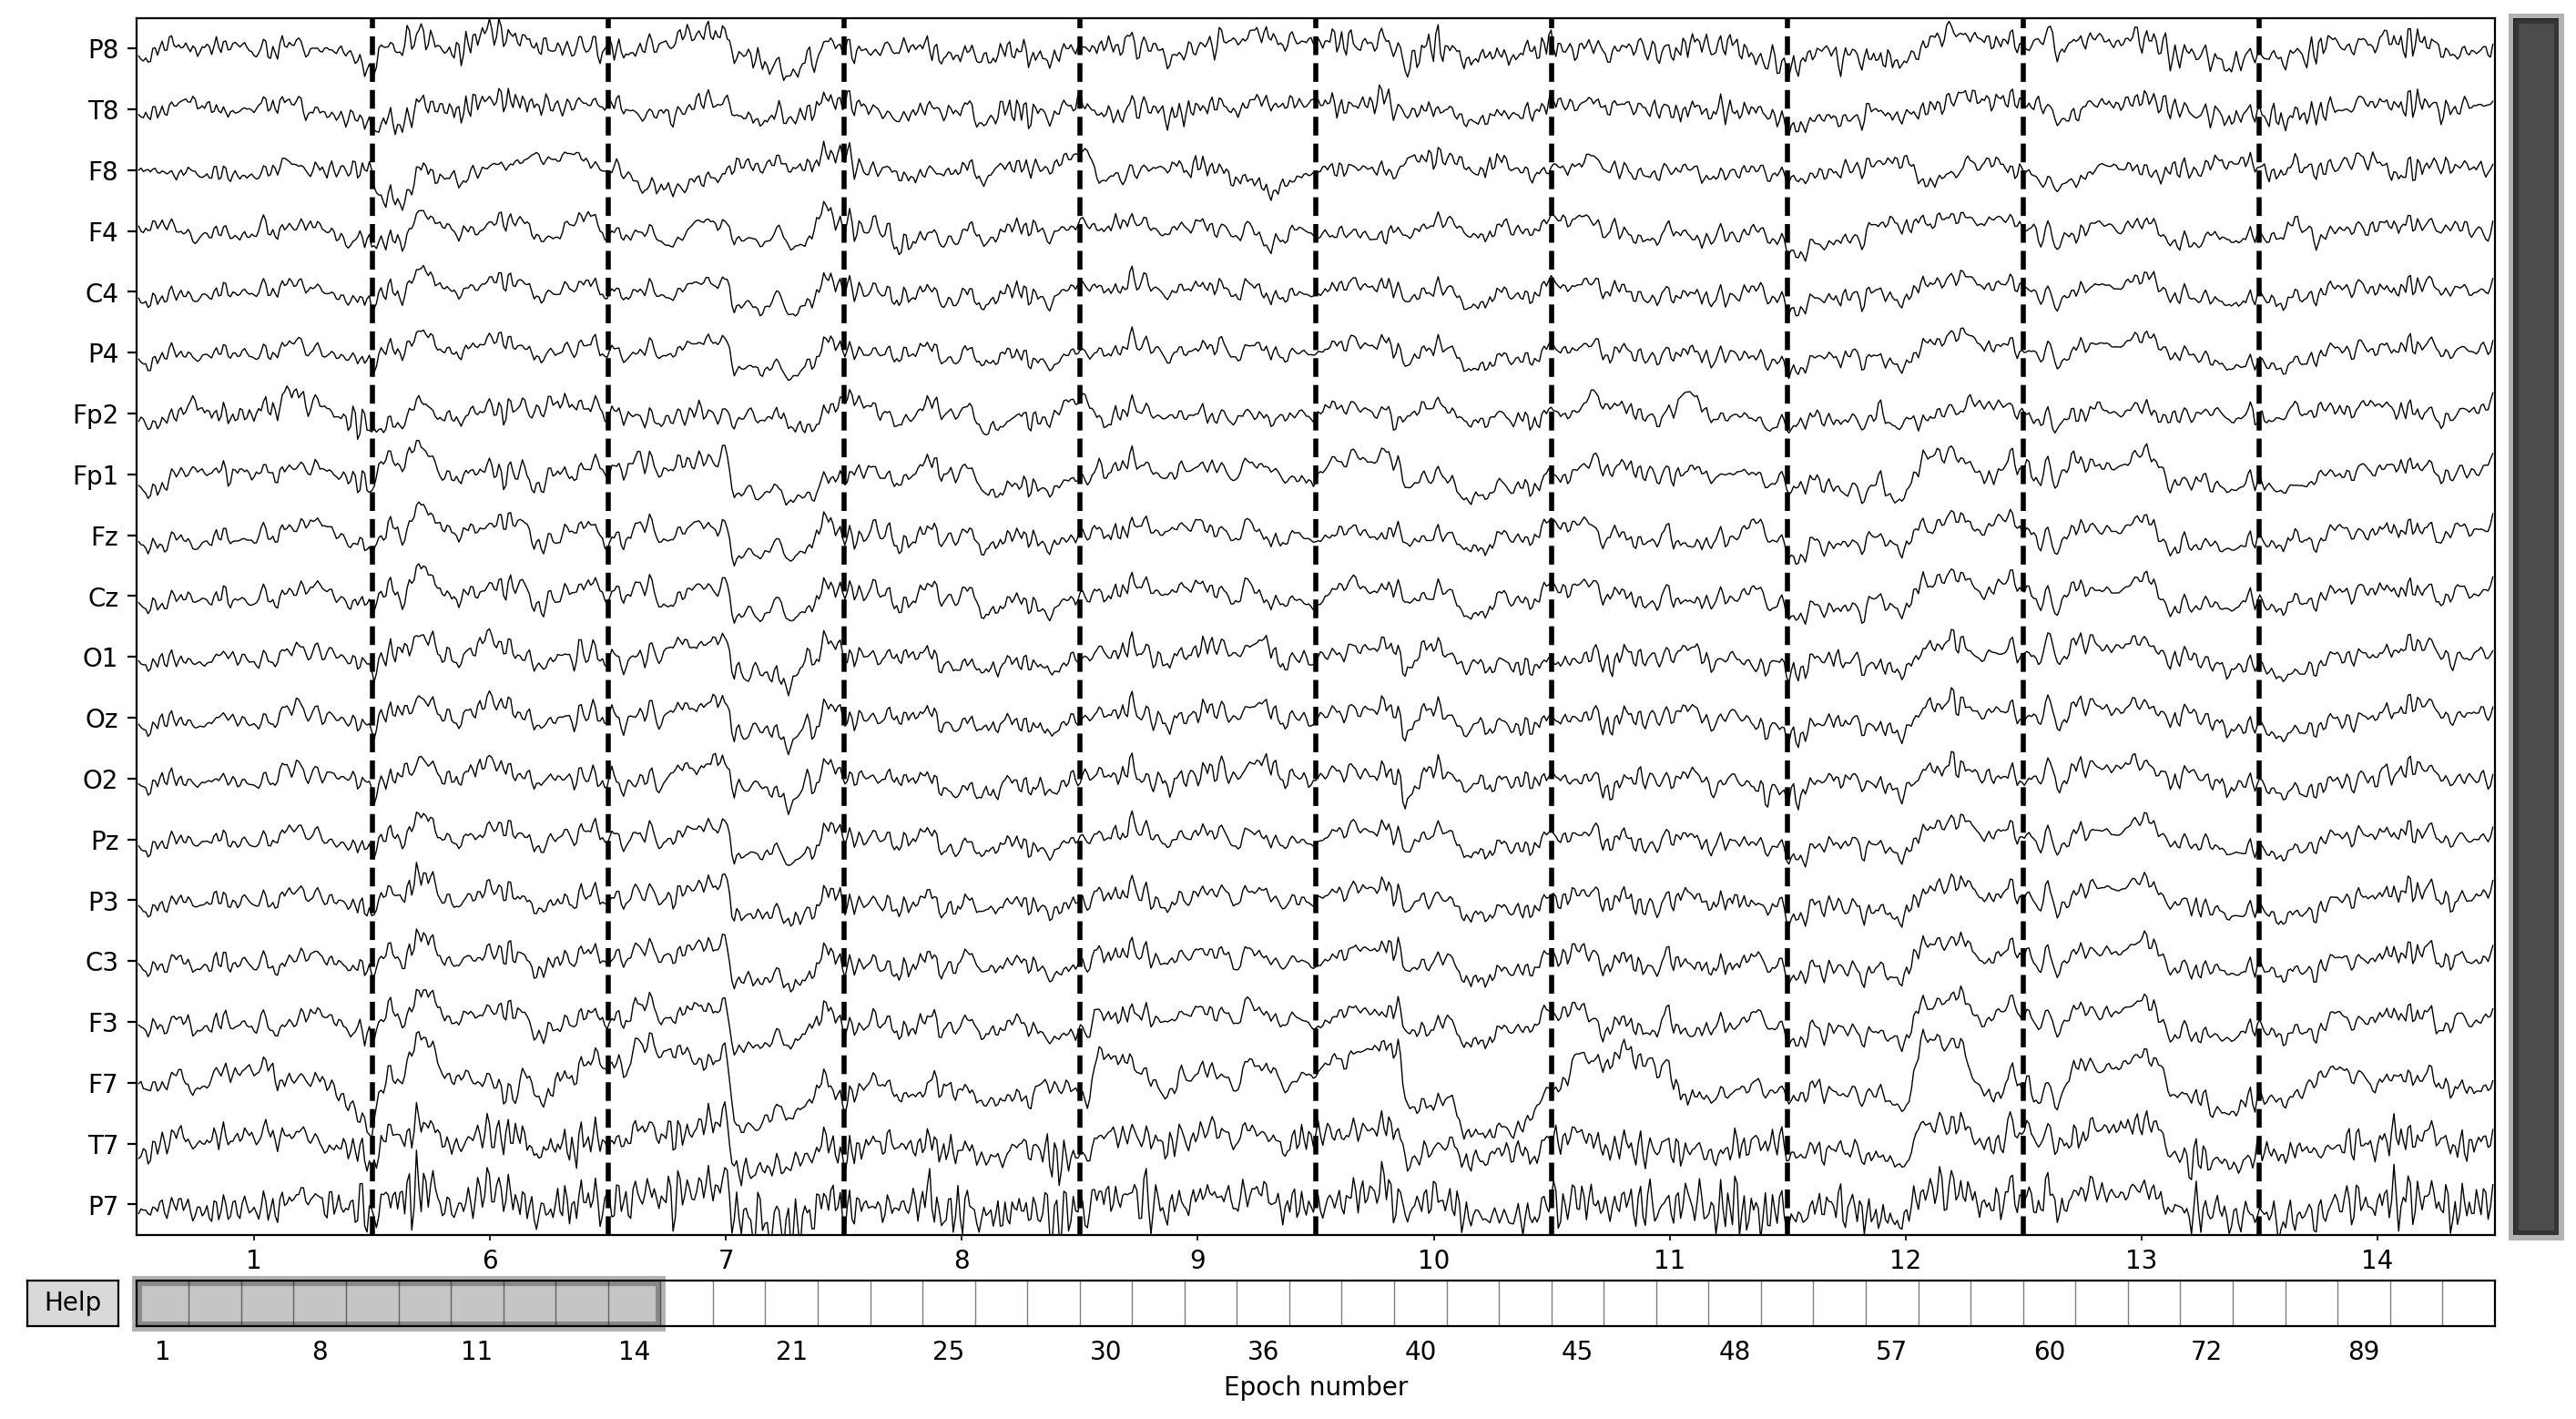

Dropped 0 epochs: 
Channels marked as bad: none


In [33]:
epochs_autoreject.plot(n_epochs=10, n_channels=32, scalings={'eeg': 20e-6},)

In [34]:
# save clean epochs
fid = epochs_autoreject.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'
epochs_autoreject.save(os.path.join(epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [35]:
# we can update the log file here, or at the end

n_bad_epochs += len([drop for drop in epochs_autoreject.drop_log if 'AUTOREJECT' in drop or 'USER' in drop])

log['fid'].update(epochs_clean_fname)
log['n_bad_epochs'].update(n_bad_epochs)
log['drop_percentage'].update(round(epochs_autoreject.drop_log_stats(), 2))

In [36]:
log

fid  highpass  lowpass  \
0  20210422171216_3_EEG PALT alatt.easy_converted...       1.0     30.0   

   n_components  n_bad_epochs  n_total_epochs  drop_percentage  t_min  t_max  \
0             1            56             101            55.88    0.0    1.0   

   n_interpolated  baseline notes  
0             NaN       NaN

In [37]:
if os.path.isfile(log_file_path):
    log.to_csv(log_file_path, mode='a', index=False, header=False)
else:
    log.to_csv(log_file_path, index=False)

### 3. Run ransac

In [18]:
settings['ransac']['threshold'] = 0.05

In [19]:
ransac = run_ransac(epochs_autoreject)

Iterating epochs ...


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


[Done]

RANSAC report
There are 3 channels that were found noisy for more than 5% of the time:
P7	0.15
F8	0.11
F4	0.06

RANSAC did not mark any of these channels to be interpolated.You can still assess the reported channels with ransac.report


[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=11)]: Done   3 out of   5 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    0.5s finished


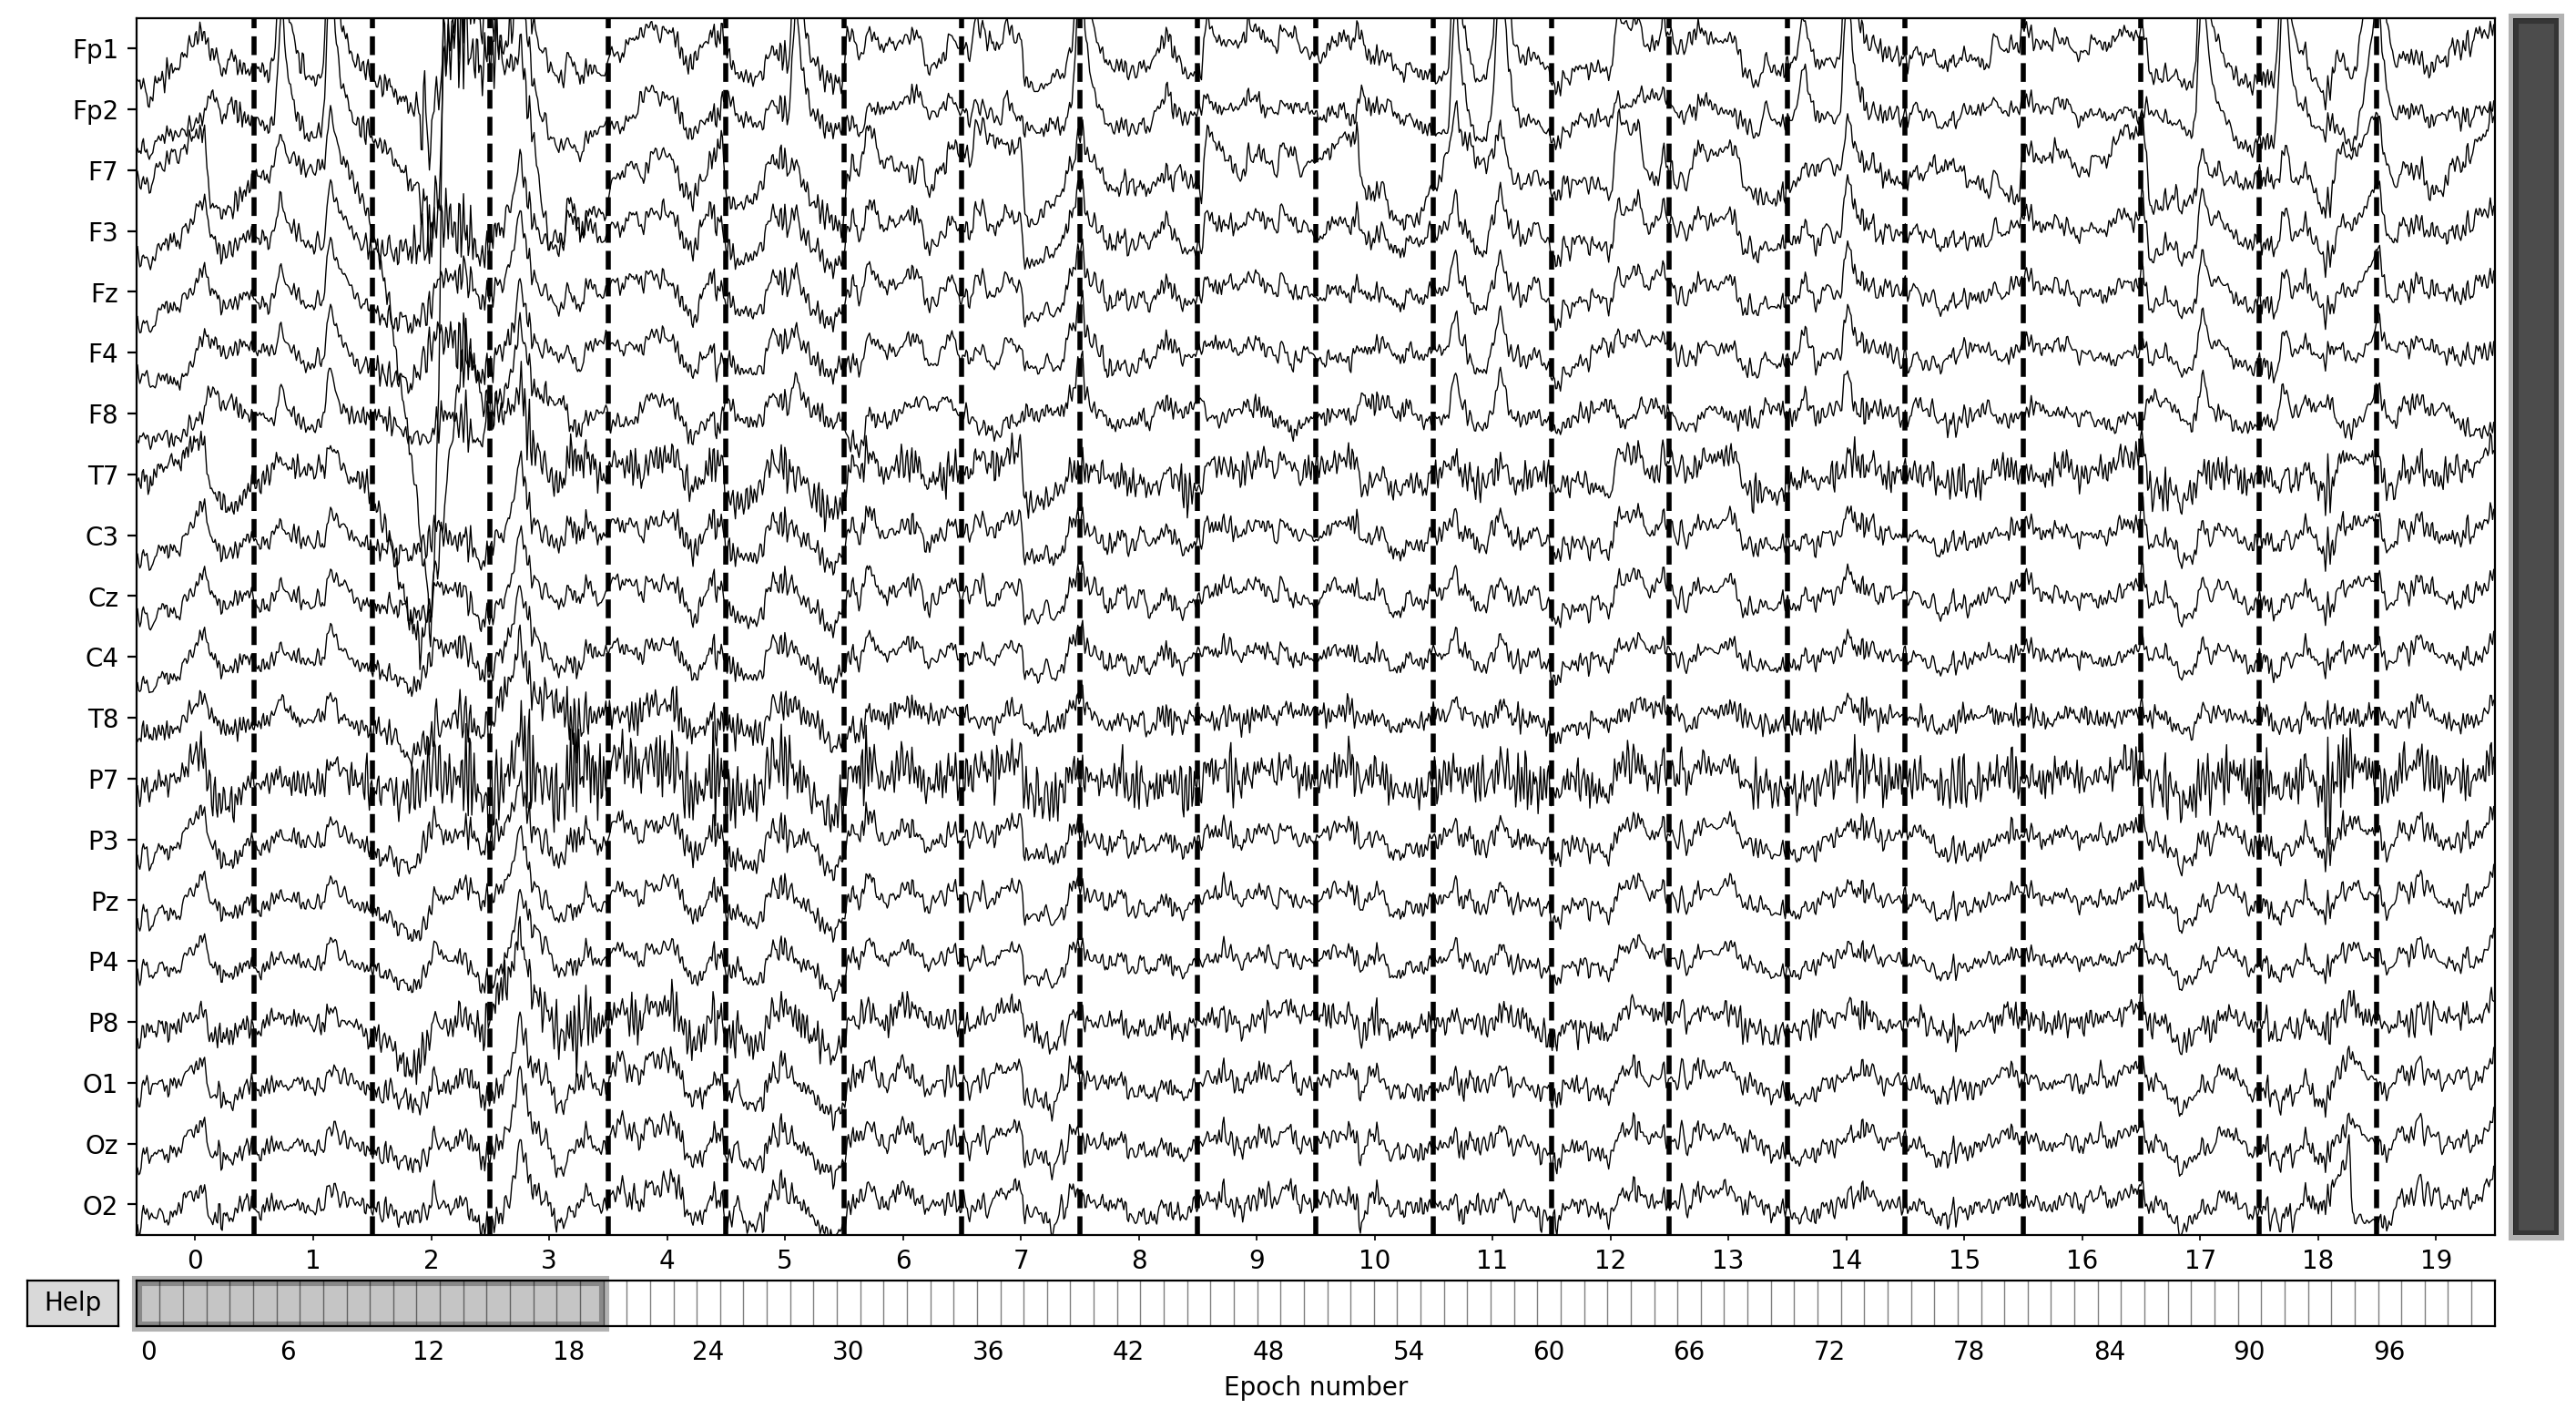

Dropped 0 epochs: 
Channels marked as bad: none


In [39]:
epochs.plot()

In [40]:
epochs_ransac = epochs_autoreject.copy()

if ransac.bad_chs_:
    epochs_ransac.info['bads'] = ransac.ransac.bad_chs_
    epochs_ransac.interpolate_bads()
    bads_str = ', '.join(ransac.ransac.bad_chs_)
    epochs_ransac.info.update(description=epochs_ransac.info['description'] + ', interpolated: ' + bads_str)
    log['n_interpolated'].update(len(ransac.ransac.bad_chs_))
    
elif ransac.report:
    epochs_ransac.info['bads'] = list(ransac.report)
    epochs_ransac.interpolate_bads()
    bads_str = ', '.join(ransac.report)
    epochs_ransac.info.update(description=epochs_ransac.info['description'] + ', interpolated: ' + bads_str)
    log['n_interpolated'].update(len(ransac.report))

Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 3 sensors


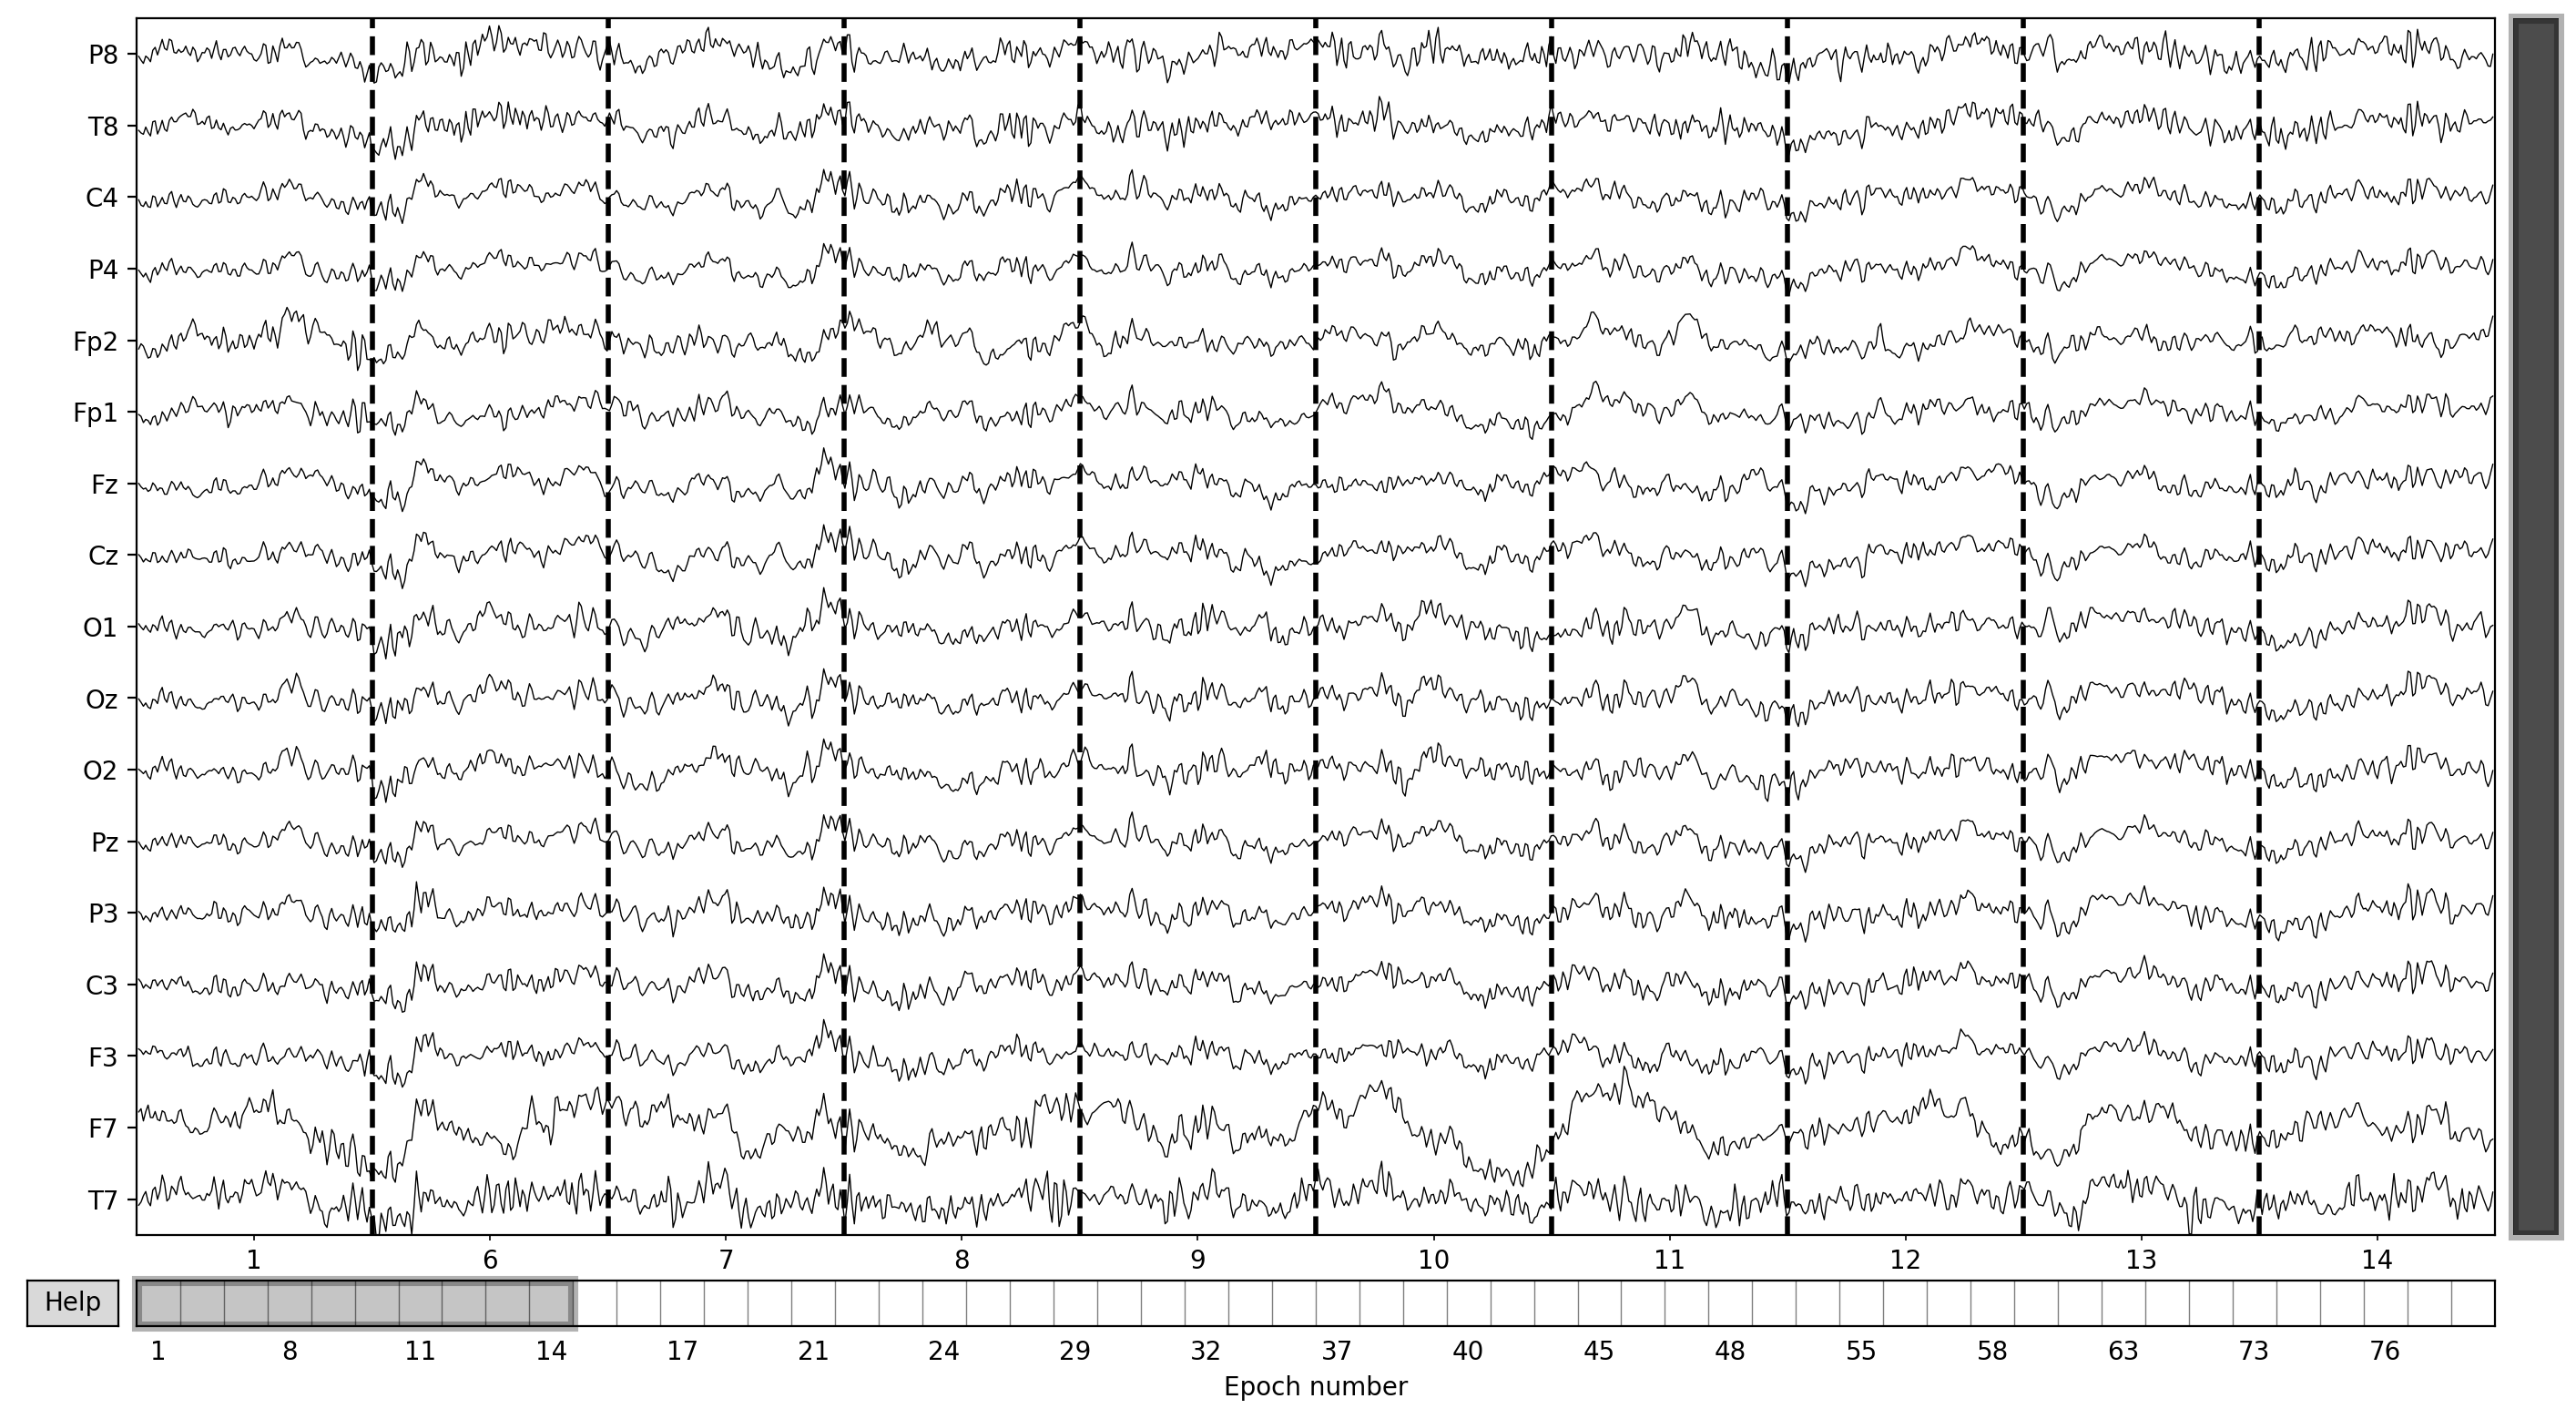

Dropped 0 epochs: 
Channels marked as bad: ['P7', 'F8', 'F4']


In [32]:
epochs_ransac.plot(n_epochs=10,
                       n_channels=32,
                       # group_by='position',
                       scalings={'eeg': 20e-6})

In [41]:
# inspect which sensors were interpolated (if any)
epochs_ransac.info

<Info | 10 non-empty values
 bads: []
 ch_names: P8, T8, F8, F4, C4, P4, Fp2, Fp1, Fz, Cz, O1, Oz, O2, Pz, P3, ...
 chs: 20 EEG
 custom_ref_applied: False
 description: n_components: 2, interpolated: P7, F8, F4
 dig: 20 items (20 EEG)
 fid: 20210422171216_3_EEG PALT alatt.easy_converted_
 highpass: 1.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2021-04-22 17:12:25 UTC
 nchan: 20
 projs: []
 sfreq: 500.0 Hz
>

### 4. Final visual inspection

Mark epochs that should be dropped, select electrodes that should be interpolated etc.

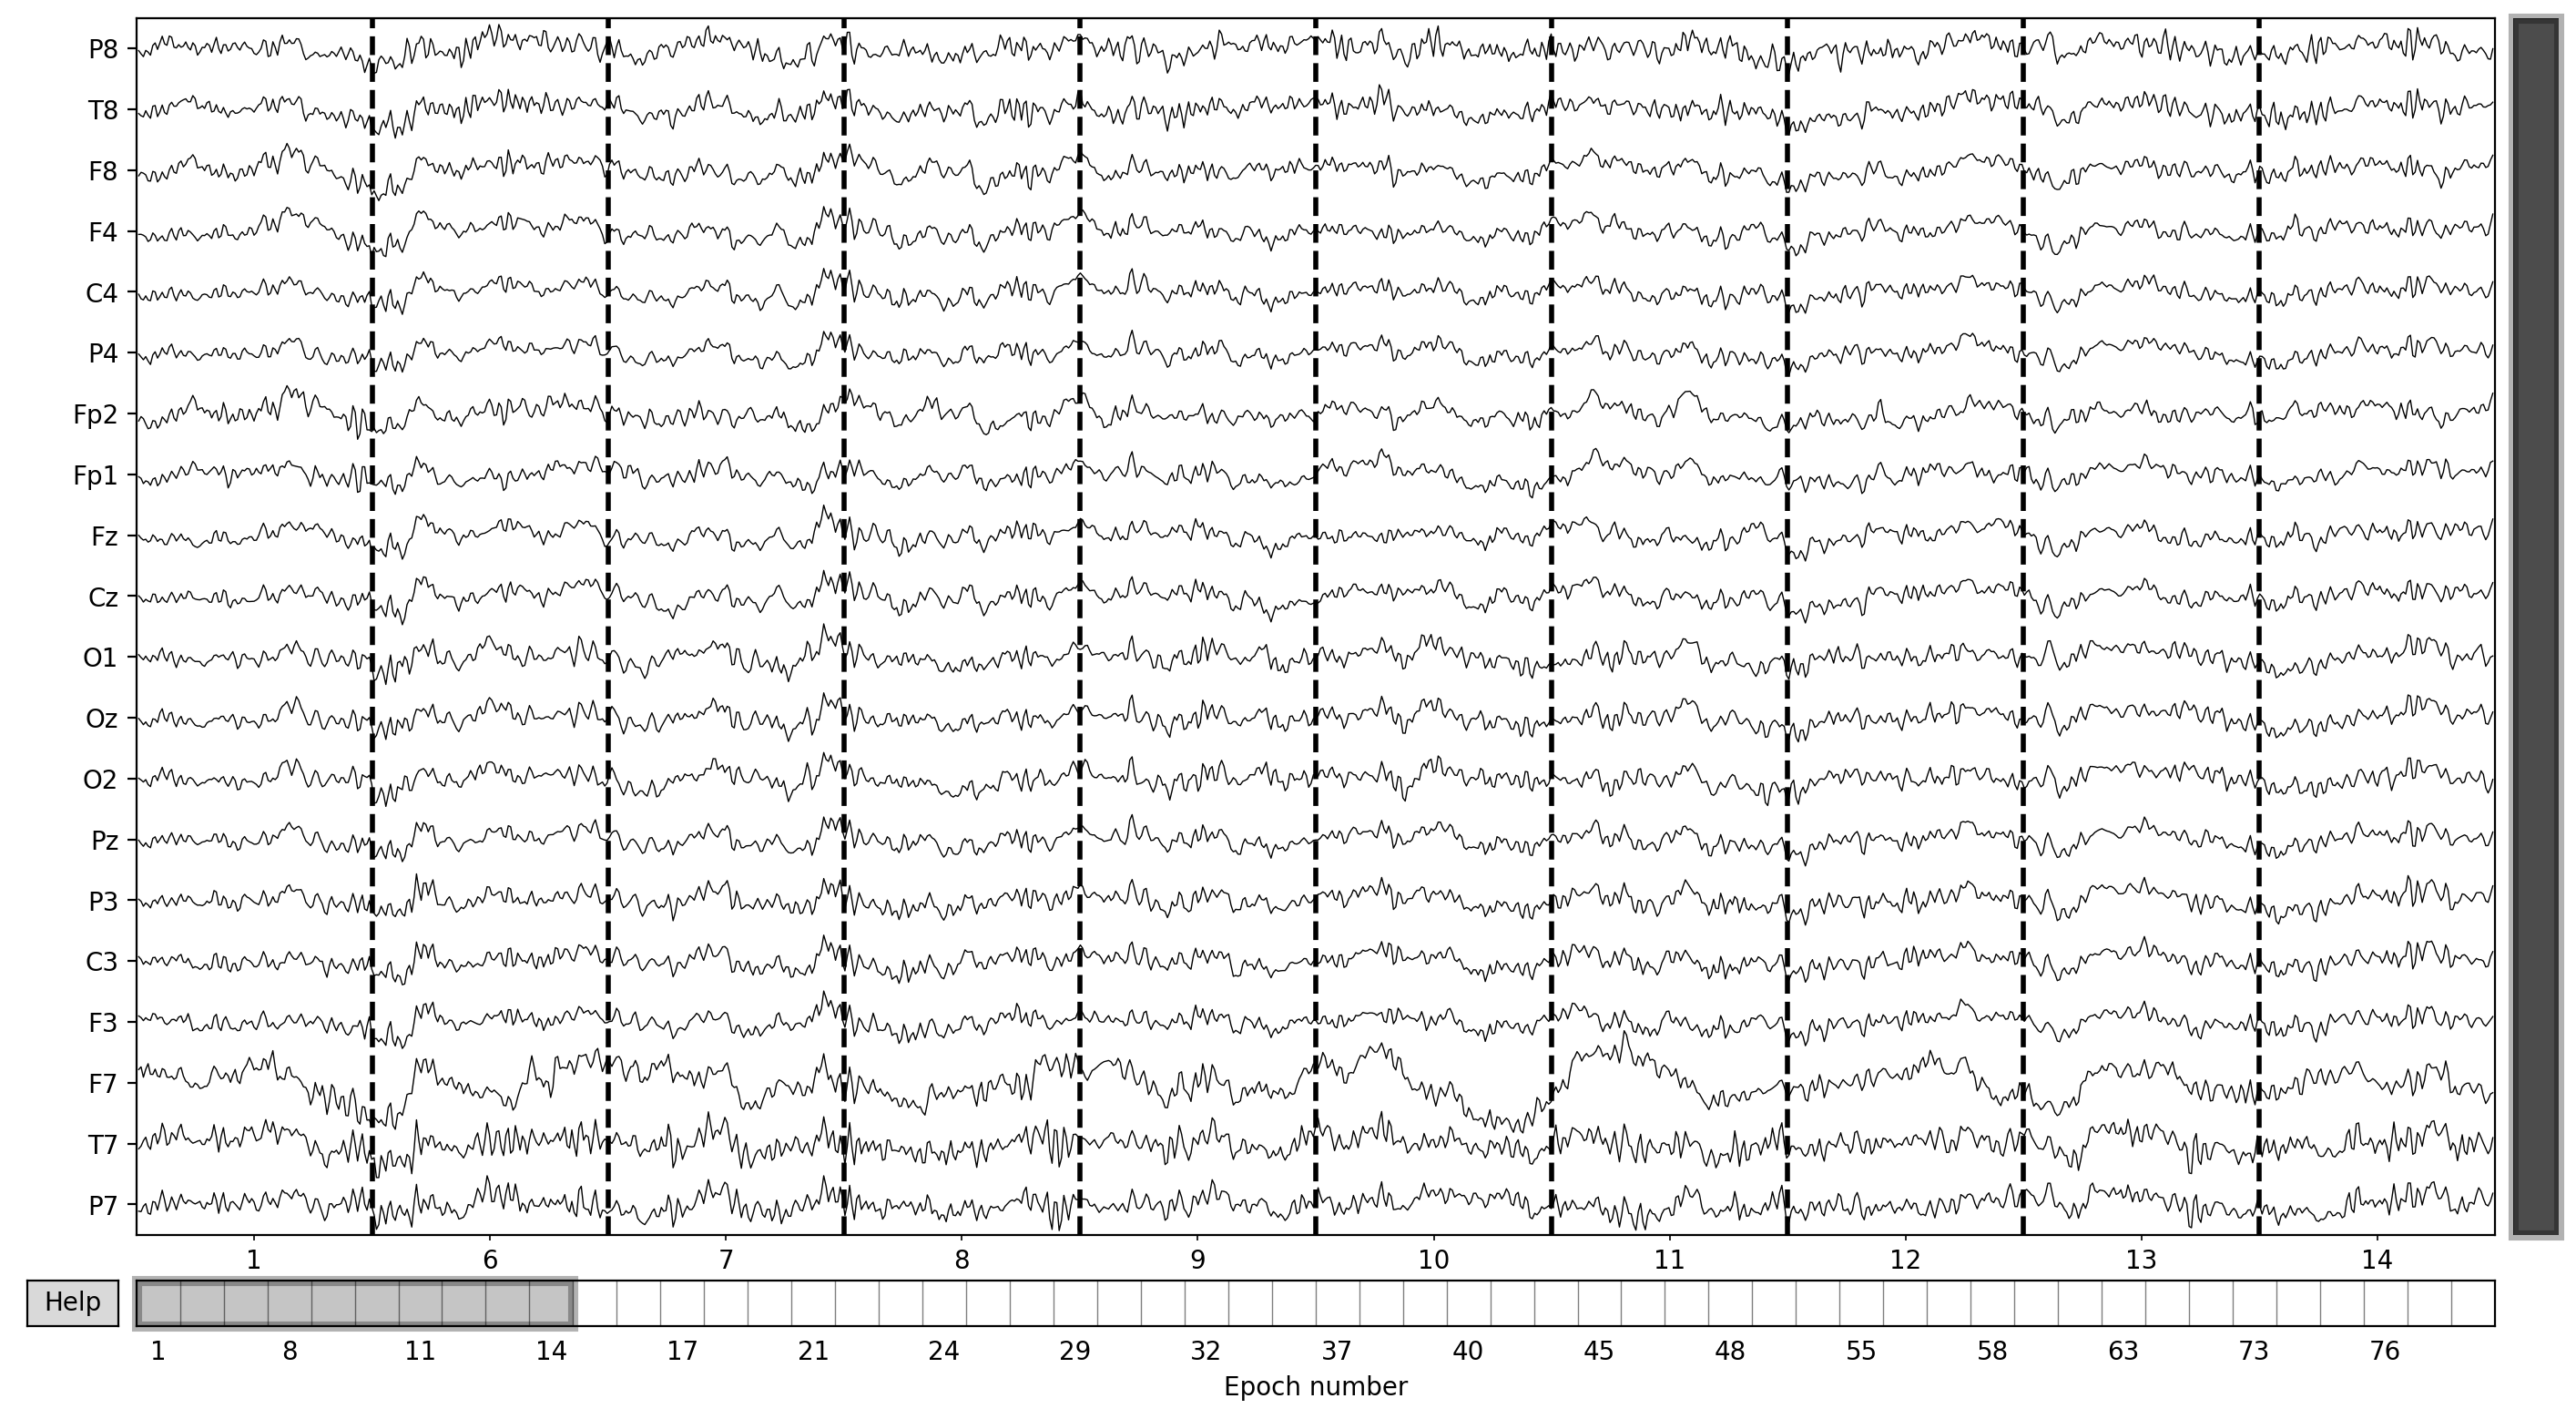

Dropped 0 epochs: 
Channels marked as bad: none


In [42]:
epochs_ransac.info['bads'] = ['Fp1', 'Fp2']

epochs_ransac.plot(n_epochs=10,
                       n_channels=32,
                       # group_by='position',
                       scalings={'eeg': 20e-6})

In [ ]:
# If you found additional channels (addition to those that were found with RANSAC)
# then you should use the epochs_autoreject object (don't interpolate the same object twice)

# example
# epochs_ransac = epochs_autoreject.copy()
# epochs_ransac.info['bads'] = ['Fp1', 'F7']
# bads_str = ', '.join(['Fp1', 'F7'])
# epochs_ransac.info.update(description=epochs_ransac.info['description'] + ', interpolated: ' + bads_str)
# log['n_interpolated'].update(len(['Fp1', 'F7']))

### 5. Set average reference

To set a “virtual reference” that is the average of all channels, you can use set_eeg_reference() with ref_channels='average'.

In [43]:
epochs_ransac.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


<Epochs |  54 events (all good), 0 - 1 sec, baseline off, ~4.2 MB, data loaded,
 '1': 54>

In [41]:
epochs_ransac.plot_drop_log()

# save clean epochs
fid = epochs_ransac.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'
epochs_ransac.save(os.path.join(epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
# cleanup from memory
del raw, epochs, epochs_autoreject, epochs_ransac

plt.close('all')

In [42]:
# if there were manual drops, those would appear with the name "USER" in the drop log
n_bad_epochs += len([drop for drop in epochs_ransac.drop_log if 'USER' in drop])

log['n_bad_epochs'].update(n_bad_epochs)
log['drop_percentage'].update(round(epochs_ransac.drop_log_stats(), 2))

log['fid'].update(epochs_clean_fname)
log['baseline'] = [epochs_ransac.baseline]

In [43]:
log

fid  highpass  lowpass  \
0  20210422171216_3_EEG PALT alatt.easy_converted...       1.0     30.0   

   n_components  n_bad_epochs  n_total_epochs  drop_percentage  t_min  t_max  \
0             1            56             101            55.88    0.0    1.0   

   n_interpolated baseline notes  
0             NaN     None

In [44]:
# Here you can add notes too
log['notes'] = 'P7 noisy'

In [45]:
if os.path.isfile(log_file_path):
    log.to_csv(log_file_path, mode='a', index=False, header=False)
else:
    log.to_csv(log_file_path, index=False)

## Time-frequency analysis

### Power

In [44]:
freqs = np.logspace(*np.log10([4, 8]), num=20)
freqs

array([4.        , 4.14862018, 4.30276234, 4.46263167, 4.62844095,
       4.80041088, 4.97877036, 5.16375679, 5.3556164 , 5.55460457,
       5.76098615, 5.97503585, 6.19703857, 6.42728981, 6.66609605,
       6.91377515, 7.17065677, 7.43708284, 7.71340798, 8.        ])

In [67]:
from mne.time_frequency import tfr_morlet

epochs_ransac.info['bads'] = ['Fp1', 'Fp2', 'F7']
power, itc = tfr_morlet(epochs_ransac,
                        freqs=freqs,
                        n_cycles=freqs/2,
                        return_itc=True, # use average=True to return ITC
                        decim=1,
                        average=True,
                        n_jobs=8)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  13 out of  16 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  16 out of  16 | elapsed:    1.0s finished


In [68]:
# simple normalization of power bins by 1/f

power_f_corrected = np.zeros_like(power.data)

# divide power by 1/f
for e in range(power.data.shape[0]):
    for f in range(power.data.shape[1]):
        power_f_corrected[e][f] = power.data[e][f] / (1/power.freqs[f])

power.data = power_f_corrected

No baseline correction applied


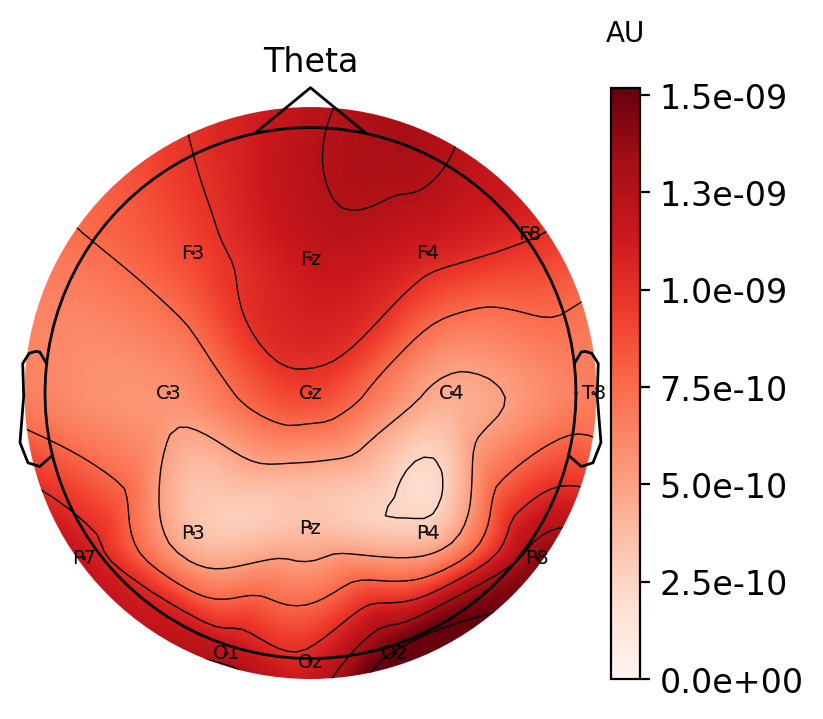

In [69]:
power.plot_topomap(fmin=4, fmax=8, mode='zlogratio', title='Theta', show=True, show_names=True, size=4)